In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle
import mr_forecast as mr
import time
import random
from astropy.io import ascii

from scipy.stats import truncnorm, powerlaw, beta, zipf, norm
from scipy.integrate import quad

%matplotlib inline

#%matplotlib notebook

## For this fake catalog, will need:
* Reasonable sets of stellar properties (Teff, logg, [Fe/H]) --- draw from Kepler target stars
* Distribution of multiplicities --- Zipfian, with parameters from our paper.
* Distribution of planet periods --- log-uniform. Check for Hill stability with each planet draw.
* Distribution of planet radii --- double-sided power law. Preference for size ordering could be enforced in the next iteration with David's mass budget idea.

## The "true" fake catalog will follow the above rules. The "false" fake catalog will not (or...(later down the line) use the real KOIs as the "fake" catalog?)

### "Wrong" fake catalog options:
* draw planet periods from uniform distribution
* draw planet radii from log-uniform distribution

### Necessary transforms: log-uniform, Zipfian, DSPL (among others).

In [2]:
def transform_uniform(x,a,b):
    return a + (b-a)*x

def transform_loguniform(x,a,b):
    la=np.log(a)
    lb=np.log(b)
    return np.exp(la + x*(lb-la))

def transform_normal(x,mu,sigma):
    return norm.ppf(x,loc=mu,scale=sigma)

def transform_beta(x,a,b):
    return beta.ppf(x,a,b)

def transform_truncated_normal(x,mu,sigma,a=0.,b=1.):
    ar, br = (a - mu) / sigma, (b - mu) / sigma
    return truncnorm.ppf(x,ar,br,loc=mu,scale=sigma)

def transform_powerlaw(x,a):
    return powerlaw.ppf(x,a+1)

def transform_zipfian(x,beta):
    #return powerlaw.ppf(x,-1-beta)
    return zipf.ppf(x,beta+1)

In [3]:
def smallplanet_prob(a_small, a_big, logRmin, logRcrit, logRmax):
    
    denom = -logRmin*(1.0+a_big) + logRcrit*(a_big-a_small) + logRmax*(1.0+a_small)
    
    sp_prob = ( (logRcrit-logRmin)*(1.0+a_big) )/denom
 
    return sp_prob


def random_smallplanet(a_small, logRmin, logRcrit):
    z = random.random() #np.random.uniform()
    
    random_smallR = z*(logRcrit - logRmin)**(1.0+a_small)
    random_smallR = logRmin + random_smallR**( 1.0/(1.0+a_small) )

    return random_smallR


def random_bigplanet(a_big, logRcrit, logRmax):
    z = random.random() #np.random.uniform()
    
    random_bigR = (1.0-z)**( 1.0/(1.0+a_big) )
    random_bigR = logRmax - random_bigR*(logRmax - logRcrit)
    
    return random_bigR



def random_planetrad(x,a_small,a_big,logRmin,logRcrit,logRmax):
    """
    return a random planet radius from a double-sided power law distribution
    """
    p_threshold = smallplanet_prob(a_small,a_big,logRmin,logRcrit,logRmax)

    if x < p_threshold:
        return random_smallplanet(a_small, logRmin, logRcrit)
    else:
        return random_bigplanet(a_big, logRcrit, logRmax)

#### Test log-uniform distribution.

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


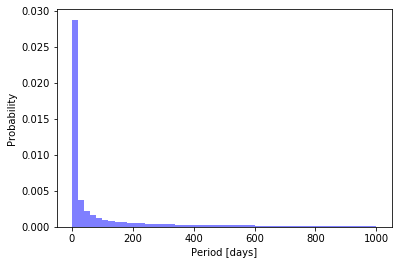

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


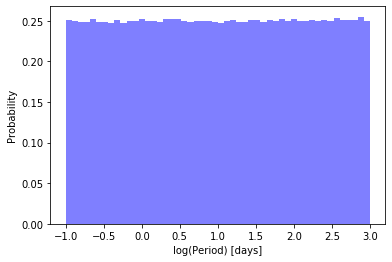

1.0


In [4]:
Pmin = 0.1 #days
Pmax = 1000. #days

random_periods = np.zeros((1000000))

for i in range(len(random_periods)):
    x = random.random() #np.random.uniform()
    random_periods[i] = transform_loguniform(x,Pmin,Pmax)

fig = plt.figure(figsize=(6,4))
n,bins,patches = plt.hist(random_periods,normed=True,bins=50,color='b',alpha=0.5)
plt.xlabel("Period [days]")
plt.ylabel("Probability")
plt.show()

fig = plt.figure(figsize=(6,4))
n,bins,patches = plt.hist(np.log10(random_periods),normed=True,bins=50,color='b',alpha=0.5)
plt.xlabel("log(Period) [days]")
plt.ylabel("Probability")
plt.show()

#check normalization
binwidths = bins[1:]-bins[0:-1]
print(np.sum(n*binwidths))

#### Test Zipfian distribution.

In [5]:
def zipf_cdf(beta_zipf,m_max):
    
    pdf = np.zeros(m_max)
    for i in range(1,m_max+1):
        pdf[i-1] = i**(-beta_zipf-1)
        
    norm = np.sum(pdf)
    
    pdf = pdf/norm
    
    cdf = np.zeros(m_max)
    
    cdf[0] = pdf[0]
    
    for i in range(2,m_max+1):
        cdf[i-1] = cdf[i-2] + pdf[i-1]
        
    return cdf

def transform_zipf(x, beta_zipf, m_max):
    cdf = zipf_cdf(beta_zipf, m_max)
    for i in range(0,m_max):
        if (x < cdf[i]):
            return i+1

10538


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


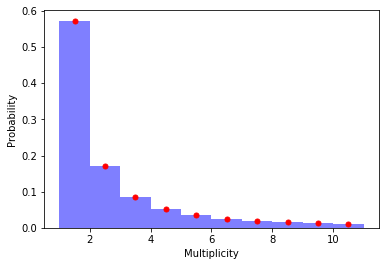

1.0


In [6]:
beta = 0.74

random_mults = np.zeros((1000000))

for i in range(len(random_mults)):
    x = random.random() #np.random.uniform()
    random_mults[i] = transform_zipf(x,beta_zipf=beta,m_max=10)

print(len(random_mults[random_mults==10]))

xs = np.arange(1,11,1)
fig = plt.figure(figsize=(6,4))
n,bins,patches = plt.hist(random_mults,normed=True,range=(1,11),bins=10,color='b',alpha=0.5)
plt.plot(xs+0.5, (xs**(-1-beta))*np.max(n),'r.',ms=10)
plt.xlabel("Multiplicity")
plt.ylabel("Probability")
plt.show()


#check normalization
binwidths = bins[1:]-bins[0:-1]
print(np.sum(n*binwidths))

In [7]:
print(np.unique(random_mults))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


#### Test DSPL transform. 
Choose some radius distribution parameters and draw a bunch of random planet radii to make sure the distribution looks right.


In [8]:
logRmin = np.log(0.5) #R_earth
logRmax = np.log(32)  #R_earth
logRcrit = np.log(2.5) #R_earth
a_small = 0.3
a_big = 4.9


random_radii = np.zeros((1000000))

for i in range(len(random_radii)):
    x = random.random() #np.random.uniform()
    random_radii[i] = random_planetrad(x,a_small,a_big,logRmin,logRcrit,logRmax)


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


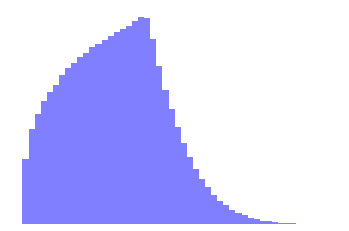

In [9]:
#small_xs = np.linspace(logRmin,logRcrit,100)
#small_ys = -0.5*(small_xs - logRmin)**(-1*a_small) + 1.02

#big_xs = (np.linspace(logRcrit+1,logRmax,100))
#big_ys = 0.6*(big_xs - logRcrit)**(-1*a_big)

fig = plt.figure(figsize=(6,4))
n,bins,patches = plt.hist(random_radii,normed=True,bins=50,color='b',alpha=0.5)
plt.xlabel("log(R_p) [R_earth]")
plt.ylabel("Probability")
#plt.axvline(logRcrit,color='r',lw=2)
plt.axis("off")
plt.show()
#plt.savefig("./DSPL.pdf",fmt="pdf")

## Check for Hill stability

In [10]:
def mass_forecast_WRONG(radius):
    c1 = 0.003460532109506489
    c2 = -0.09252481979252211
    c3 = 1.2489241453022766
    c4 = -2.844669555228572
    s1= 0.279
    s2= 0.589
    s3 = -0.044
    s4 = 0.881
    t1 = 0.3096301674258988
    t2 = 2.1191926778748793
    t3 = 4.425506703276593
    t4 = 0.0
 
    logR = np.log10(radius)
    if logR < t1:
        logM = (logR - c1)/s1
    elif logR < t2:
        logM = (logR - c2)/s2
    elif logR < t3:
        logM = (logR - c3)/s3
    else:
        logM = (logR - c4)/s4
    
    
    return 10**logM

In [11]:
def mass_forecast(radius):
    """
    Extremely basic, as-deterministic-as-possible implementation of Jingjing's Forecaster code.
    Take a radius, evaluate the mass value from the Forecaster broken power law fit.
    The only probabilistic regime high Neptunian - low Stellar.
    
    R/Rearth = C * (M/Mearth)**S
    
    log(M/Mearth) = (log(R/Rearth) - logC)/S
    Parameters
    ---------
    radius : float
        Planet radius in Rearth
    Returns
    ---------
    mass : float
        Planet mass in Mearth
    """
    
    #### what is so slow about this now?????
    
    # 10**c has units of Rearth. c1 is fit; c2-c4 are derived iteratively, assuming segments meet at transition points.
    c1 = 0.003460532109506489 
    c2 = -0.09252481979252211
    c3 = 1.2489241453022766
    c4 = -2.844669555228572
    
    # power-law indices; unitless
    s1 = 0.279
    s2 = 0.589
    s3 = -0.044
    s4 = 0.881
    
    # transition points, units of log(Mearth)
    t1 = 0.3096301674258988 # log10(2.04 Mearth)                        Terran -> Neptunian
    t2 = 2.1191926778748793 # log10(0.414 Mjup * 317.828 Mearth/Mjup)   Neptunian -> Jovian
    t3 = 4.425506703276593  # log10(0.0800 Msun * 333060.4 Mearth/Msun) Jovian -> Stellar
    
    # corresponding transition points in units of log(Rearth)
    # computed from mr.Mstat2R(transition points above)
    t1_r = 0.09691001300805642 #np.log10(1.25)   Terran -> Neptunian
    t2_r = 1.1417632302757879  #np.log10(13.86)  Neptunian -> Jovian
    t3_r = 1.064083435963596   #np.log10(11.59)  Jovian -> Stellar
    
    
    logR = np.log10(radius)
    
    if logR <= t1_r: #unambiguously Terran
        logM = (logR - c1)/s1
        
    elif logR <= t3_r: #unambiguously Neptunian
        logM = (logR - c2)/s2
    
    elif logR > t2_r: #unambiguously stellar
        logM = (logR - c4)/s4
    
        
    else: # could be Neptunian, could be Jovian, could be stellar
        # based on monte carlo tests from Jingjing's code,
        # the breakdown of neptunians vs. jovians vs. stellars
        # in this radius range is:
        frac_neptunian = 0.08842
        frac_jovian = 0.839126
        frac_stellar = 0.072454
        rando = random.random() # should be significantly faster than np.random.uniform()

        if rando <= frac_neptunian: #Neptunian
            logM = (logR - c2)/s2
        elif rando <= (frac_neptunian + frac_jovian): #Jovian
            logM = (logR - c3)/s3
        else: #stellar
            logM = (logR - c4)/s4
    
    return 10.**logM #Earth masses


In [12]:
'''
def mass_forecast_jc(radius, sigma_radius):
    """
    Use Jingjing's code.
    
    Parameters
    ---------
    radius : float
        Radius in Rearth
    sigma_radius : float
        Radius uncertainty in Rearth
    
    Returns
    ---------
    mass : float
        Median predicted mass in Mearth
    """
    
    mass, massplus, massminus = mr.Rstat2M(radius, sigma_radius, unit='Earth', sample_size=1000, grid_size=1000)
    
    return mass, massplus, massminus
'''

'\ndef mass_forecast_jc(radius, sigma_radius):\n    """\n    Use Jingjing\'s code.\n    \n    Parameters\n    ---------\n    radius : float\n        Radius in Rearth\n    sigma_radius : float\n        Radius uncertainty in Rearth\n    \n    Returns\n    ---------\n    mass : float\n        Median predicted mass in Mearth\n    """\n    \n    mass, massplus, massminus = mr.Rstat2M(radius, sigma_radius, unit=\'Earth\', sample_size=1000, grid_size=1000)\n    \n    return mass, massplus, massminus\n'

In [13]:
"""
t0 = time.time()
masses = np.zeros((1))
masses = np.atleast_2d(masses)
sample_size=100

for i in range(5000):
    if i%500==0:
        print(i)
    randomRadius = np.random.uniform(11.59,13.86)
    randomRadius = truncnorm.rvs( (0.-randomRadius)/0.001, np.inf, loc=randomRadius, scale=0.001, size=int(sample_size))
    randomRadius = randomRadius[(randomRadius > 0.1) & (randomRadius < 100.)]
    m_arr = mr.Rpost2M(randomRadius, unit='Earth', classify = 'No')
    m_arr = np.atleast_2d(m_arr)

    masses = np.vstack((masses,m_arr.T))

t1 = time.time()

t = t1-t0
print(t/60.)

masses = masses[np.isfinite(masses)]
masses = masses[masses > 0.]
print(np.min(masses))
print(np.max(masses))

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].hist(masses, color='b',alpha=0.5)
axes[0].set_xlabel("Mass [Mearth]")
axes[1].hist(np.log10(masses), color='r',alpha=0.5)
axes[1].set_xlabel("log10(Mass [Mearth])")
plt.show()

frac_neptunian = len(masses[np.log10(masses) <= 2.1191926778748793])/len(masses)
frac_jovian = len(masses[(np.log10(masses) > 2.1191926778748793) & (np.log10(masses) <= 4.425506703276593)])/len(masses)
frac_stellar = len(masses[np.log10(masses) > 4.425506703276593])/len(masses)

print(frac_neptunian)
print(frac_jovian)
print(frac_stellar)

print(frac_neptunian + frac_jovian + frac_stellar)
"""

'\nt0 = time.time()\nmasses = np.zeros((1))\nmasses = np.atleast_2d(masses)\nsample_size=100\n\nfor i in range(5000):\n    if i%500==0:\n        print(i)\n    randomRadius = np.random.uniform(11.59,13.86)\n    randomRadius = truncnorm.rvs( (0.-randomRadius)/0.001, np.inf, loc=randomRadius, scale=0.001, size=int(sample_size))\n    randomRadius = randomRadius[(randomRadius > 0.1) & (randomRadius < 100.)]\n    m_arr = mr.Rpost2M(randomRadius, unit=\'Earth\', classify = \'No\')\n    m_arr = np.atleast_2d(m_arr)\n\n    masses = np.vstack((masses,m_arr.T))\n\nt1 = time.time()\n\nt = t1-t0\nprint(t/60.)\n\nmasses = masses[np.isfinite(masses)]\nmasses = masses[masses > 0.]\nprint(np.min(masses))\nprint(np.max(masses))\n\nfig, axes = plt.subplots(1,2,figsize=(10,5))\naxes[0].hist(masses, color=\'b\',alpha=0.5)\naxes[0].set_xlabel("Mass [Mearth]")\naxes[1].hist(np.log10(masses), color=\'r\',alpha=0.5)\naxes[1].set_xlabel("log10(Mass [Mearth])")\nplt.show()\n\nfrac_neptunian = len(masses[np.log10

In [14]:
def delta_Hill(Mstar,radius1,radius2,period1,period2):
    """
    Parameters
    ---------
    Mstar : float
        Solar masses
    radius1 : float
        Earth radii
    radius2 : float
        Earth radii
    period1 : float
        Days
    period2 : float
        Days
    """
    
    mass1 = mass_forecast(radius1)
    mass2 = mass_forecast(radius2)
    
    mass_star = Mstar*332978.9015405224 #convert solar masses to Earth masses

    ratio = 2.8844991406148166/( (mass1+mass2)/mass_star )**(1./3.)
    
    
    periodx_inner = (np.min((period1,period2)))**(2./3.)
    periodx_outer = (np.max((period1,period2)))**(2./3.)
    
    dH = ratio*( (periodx_outer-periodx_inner)/(periodx_outer+periodx_inner) )
    
    return dH

In [15]:
def hill_stability(mstar,nplanets,radii,periods):
    """
    Parameters
    ---------
    mstar : float
        Stellar mass in solar masses
    nplanets : int
        Number of planets in system
    radii : np.array 
        Array of planet radii in *Earth* radii
    periods : np.array
        Array of planet periods in days
    
    Returns
    ---------
    True if stable, False if not
    """
    
    if nplanets == 1: #only one planet---always stable
        return True
    
    elif nplanets == 2:
        if delta_Hill(mstar, radii[0], radii[1], periods[0], periods[1]) > 3.4641016151377544:
            return True
        
    else:
        #assume stable until proven otherwises
        
        #test 1: go through pairs, from eq 8 of 2014ApJ...790..146F
        
        for i in range(0,nplanets-1):
            if delta_Hill(mstar, radii[i], radii[i+1], periods[i], periods[i+1]) <= 3.4641016151377544:
                return False
        
        #test 2: go through triples, from eq 9 of 2014ApJ...790..146F
        for i in range(0, nplanets-2):
            if (delta_Hill(mstar, radii[i], radii[i+1], periods[i], periods[i+1]) + 
                delta_Hill(mstar, radii[i+1], radii[i+2], periods[i+1], periods[i+2])) <= 18.:
                return False
        
        return True

In [16]:
#radii = np.concatenate((np.linspace(-1.5,2.5,1000), np.linspace(1.,1.4,1000)))
radii = np.linspace(-1.5,2.5,5000)
radii = np.sort(radii)
radii = 10.**radii

masses = np.zeros_like(radii)
masses_wrong = np.zeros_like(radii)

for i,r in enumerate(radii):
    masses[i] = mass_forecast(r)
    masses_wrong[i] = mass_forecast_WRONG(r)
    

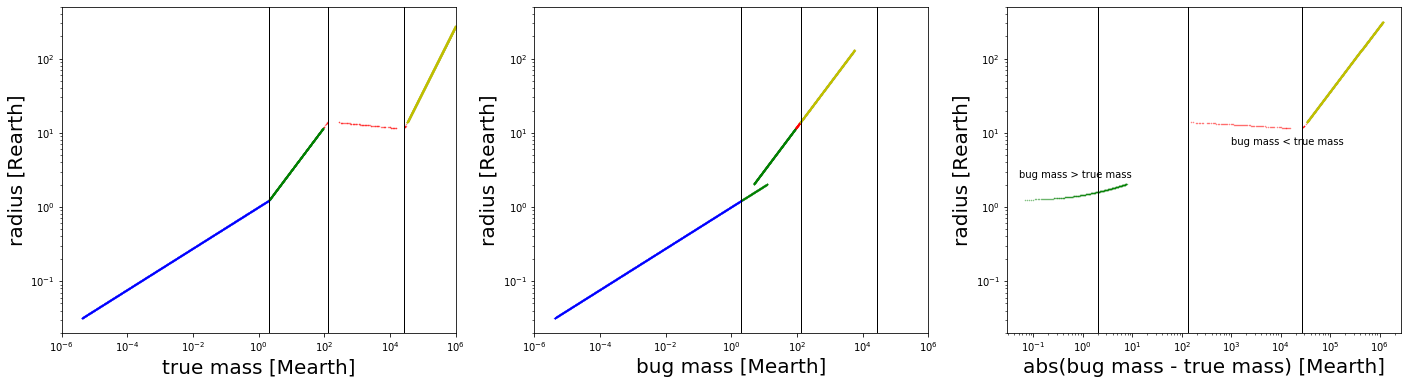

In [17]:
dmass = np.abs(masses_wrong - masses)

fig,axes = plt.subplots(1,3,figsize=(24,6))
#axes[0].plot(masses,radii,color='k',marker='.',ls='None',ms=1,alpha=0.25)
axes[0].plot(masses[radii < 1.25],radii[radii < 1.25],color='b',marker='.',ls='None',ms=1,alpha=0.5)
axes[0].plot(masses[(radii > 1.25) & (radii < 11.59)],radii[(radii > 1.25) & (radii < 11.59)],color='g',marker='.',ls='None',ms=1,alpha=0.5)
axes[0].plot(masses[(radii > 11.59) & (radii < 13.86)],radii[(radii > 11.59) & (radii < 13.86)],color='r',marker='.',ls='None',ms=1,alpha=0.5)
axes[0].plot(masses[radii > 13.86],radii[radii > 13.86],color='y',marker='.',ls='None',ms=1,alpha=0.5)

axes[0].axvline(10**0.3096301674258988,color='k',lw=1)
axes[0].axvline(10**2.1191926778748793,color='k',lw=1)
axes[0].axvline(10**4.425506703276593,color='k',lw=1)
axes[0].set_xlabel('true mass [Mearth]',fontsize=20)
axes[0].set_ylabel('radius [Rearth]',fontsize=20)
axes[0].loglog()
axes[0].set_xlim(1.e-6,1.e6)

#axes[1].plot(masses_wrong,radii,color='k',marker='.',ls='None',ms=1,alpha=0.25)
axes[1].plot(masses_wrong[radii < 1.25],radii[radii < 1.25],color='b',marker='.',ls='None',ms=1,alpha=0.5)
axes[1].plot(masses_wrong[(radii > 1.25) & (radii < 11.59)],radii[(radii > 1.25) & (radii < 11.59)],color='g',marker='.',ls='None',ms=1,alpha=0.5)
axes[1].plot(masses_wrong[(radii > 11.59) & (radii < 13.86)],radii[(radii > 11.59) & (radii < 13.86)],color='r',marker='.',ls='None',ms=1,alpha=0.5)
axes[1].plot(masses_wrong[radii > 13.86],radii[radii > 13.86],color='y',marker='.',ls='None',ms=1,alpha=0.5)

axes[1].axvline(10**0.3096301674258988,color='k',lw=1)
axes[1].axvline(10**2.1191926778748793,color='k',lw=1)
axes[1].axvline(10**4.425506703276593,color='k',lw=1)
axes[1].set_xlabel('bug mass [Mearth]',fontsize=20)
axes[1].set_ylabel('radius [Rearth]',fontsize=20)
axes[1].loglog()
axes[1].set_xlim(1.e-6,1.e6)

axes[2].plot(dmass[radii < 1.25],radii[radii < 1.25],color='b',marker='.',ls='None',ms=1,alpha=0.5)
axes[2].plot(dmass[(radii > 1.25) & (radii < 11.59)],radii[(radii > 1.25) & (radii < 11.59)],color='g',marker='.',ls='None',ms=1,alpha=0.5)
axes[2].plot(dmass[(radii > 11.59) & (radii < 13.86)],radii[(radii > 11.59) & (radii < 13.86)],color='r',marker='.',ls='None',ms=1,alpha=0.5)
axes[2].plot(dmass[radii > 13.86],radii[radii > 13.86],color='y',marker='.',ls='None',ms=1,alpha=0.5)

axes[2].axvline(10**0.3096301674258988,color='k',lw=1)
axes[2].axvline(10**2.1191926778748793,color='k',lw=1)
axes[2].axvline(10**4.425506703276593,color='k',lw=1)
axes[2].set_xlabel('abs(bug mass - true mass) [Mearth]',fontsize=20)
axes[2].set_ylabel('radius [Rearth]',fontsize=20)
axes[2].loglog()
axes[2].text(0.05,2.5,"bug mass > true mass")
axes[2].text(1e3,7,"bug mass < true mass")
#axes[2].set_xlim(1.e-6,1.e6)
#plt.show()
plt.savefig("forecaster_bug.pdf",fmt="pdf")

#fig = plt.figure(figsize=(8,6))
#plt.plot(radii,masses,color='k',marker='.',ls='None',ms=1,alpha=0.25)
#plt.axhline(10**0.3096301674258988,color='r')
#plt.axhline(10**2.1191926778748793,color='r')
#plt.axhline(10**4.425506703276593,color='r')
#plt.xlabel('radius',fontsize=20)
#plt.ylabel('mass',fontsize=20)
#plt.loglog()
#plt.show()

# Make fakes!

### Instead of the entire Kepler stellar catalog, use only the Kepler planet hosts (do lots of draws from within 1-sigma error bars so we have enough stars)

6973
6973
(6973,)
5455.0


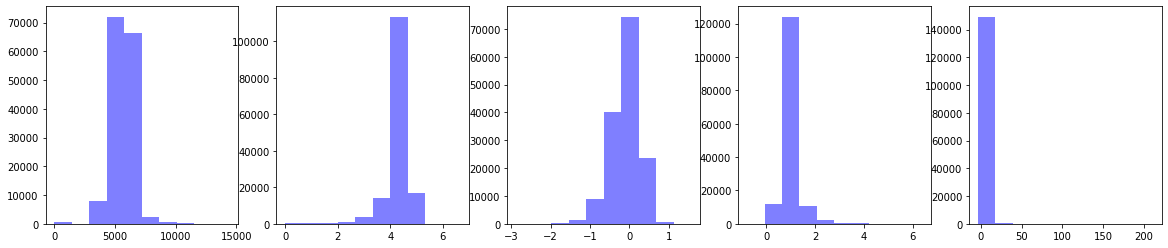

In [18]:
planetHosts = ascii.read("../../../../KOIs_chen2018.csv")
planetHosts = planetHosts["koi_steff","koi_steff_err1","koi_steff_err2",
                         "koi_slogg","koi_slogg_err1","koi_slogg_err2",
                         "koi_smet","koi_smet_err1","koi_smet_err2",
                         "koi_smass","koi_smass_err1","koi_smass_err2",
                         "koi_srad","koi_srad_err1","koi_srad_err2"]

print(len(planetHosts))
noNans = (~np.isnan(np.array(planetHosts['koi_steff']))) & (~np.isnan(np.array(planetHosts['koi_steff_err1']))) & (~np.isnan(np.array(planetHosts['koi_steff_err2']))) & (~np.isnan(np.array(planetHosts['koi_slogg']))) & (~np.isnan(np.array(planetHosts['koi_slogg_err1']))) & (~np.isnan(np.array(planetHosts['koi_slogg_err2']))) & (~np.isnan(np.array(planetHosts['koi_smet']))) & (~np.isnan(np.array(planetHosts['koi_smet_err1']))) & (~np.isnan(np.array(planetHosts['koi_smet_err2']))) & (~np.isnan(np.array(planetHosts['koi_smass']))) & (~np.isnan(np.array(planetHosts['koi_smass_err1']))) & (~np.isnan(np.array(planetHosts['koi_smass_err2']))) & (~np.isnan(np.array(planetHosts['koi_srad']))) & (~np.isnan(np.array(planetHosts['koi_srad_err1']))) & (~np.isnan(np.array(planetHosts['koi_srad_err2'])))

planetHosts = planetHosts[noNans]

print(len(planetHosts))
planetHosts = np.array((planetHosts))
print(np.shape(planetHosts))
print(planetHosts[0][0])

# do lots of random draws
nDraws = 150000

planetHostsArr = np.zeros((nDraws,5))

for i in range(nDraws):
#for i in range(10):
    for j in range(5):
        rando = np.random.randint(low=0,high=len(planetHosts))
        planetHostsArr[i,j] = np.random.normal(loc=planetHosts[rando][3*j], scale=0.5*(np.abs(planetHosts[rando][3*j + 1]) + np.abs(planetHosts[rando][3*j + 2])),size=1)
        
fig, axes = plt.subplots(1,5,figsize=(20,4))
for i in range(5):
    axes[i].hist(planetHostsArr[:,i],color='b',alpha=0.5)
plt.show()


np.save("../../../../kepStellar_fromPlanetHosts.npy",planetHostsArr)


(150000, 5)
(150000, 5)
(146504, 5)
(145786, 5)
(144283, 5)


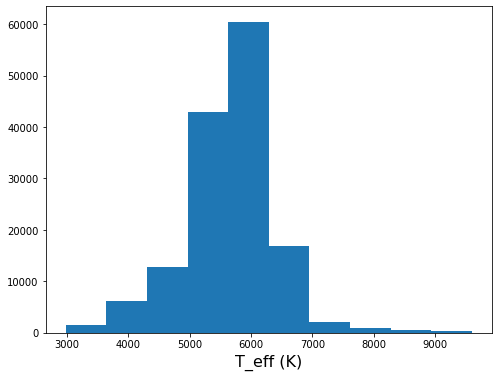

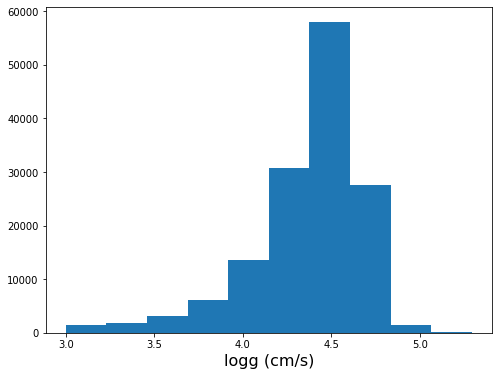

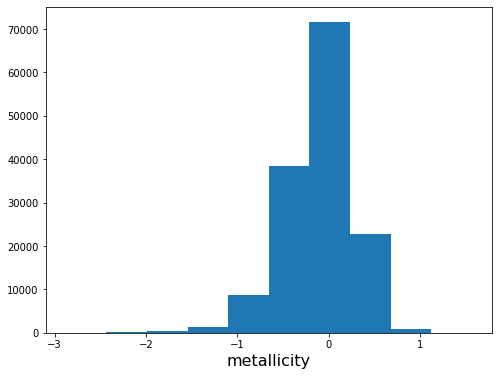

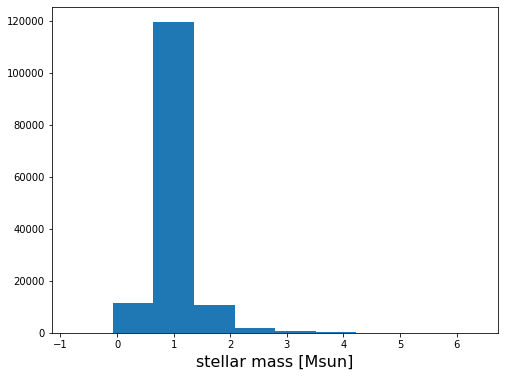

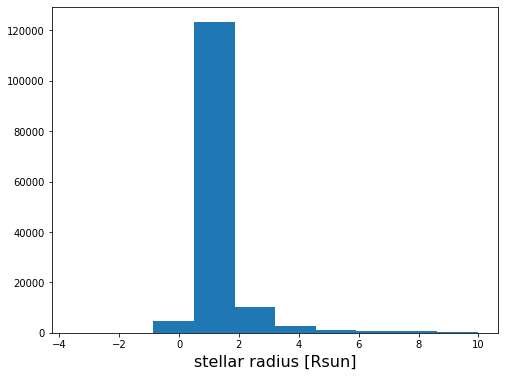

In [19]:
#columns: Teff, logg, [Fe/H], mass, radius
#kepStellar = np.genfromtxt("../../../../kepStellar.csv",delimiter=',')
kepStellar = np.load("../../../../kepStellar_fromPlanetHosts.npy")
print(np.shape(kepStellar))

#remove nans
nonans = (np.isfinite(kepStellar[:,0]) & 
          np.isfinite(kepStellar[:,1]) & 
          np.isfinite(kepStellar[:,2]) & 
          np.isfinite(kepStellar[:,3]) & 
          np.isfinite(kepStellar[:,4]))
kepStellar = kepStellar[nonans]
print(np.shape(kepStellar))

#select only dwarfs
kepStellar = kepStellar[(kepStellar[:,1] > 3.) & (kepStellar[:,1] < 5.3)]
print(np.shape(kepStellar))

#select only FGKM
kepStellar = kepStellar[(kepStellar[:,0] > 2400.) & (kepStellar[:,0] < 9600.)]
print(np.shape(kepStellar))

#metallicity cut? nah
#print(np.min(kepStellar[:,2]))
#print(np.max(kepStellar[:,2]))

#mass cut
#kepStellar = kepStellar[(kepStellar[:,3] > 0.13) & (kepStellar[:,3] < 2.7)]
#print(np.shape(kepStellar))

#radius cut
kepStellar = kepStellar[kepStellar[:,4] < 10]
print(np.shape(kepStellar))


fig = plt.figure(figsize=(8,6))
plt.hist(kepStellar[:,0])
plt.xlabel("T_eff (K)",fontsize=16)
plt.show()

fig = plt.figure(figsize=(8,6))
plt.hist(kepStellar[:,1])
plt.xlabel("logg (cm/s)",fontsize=16)
plt.show()

fig = plt.figure(figsize=(8,6))
plt.hist(kepStellar[:,2])
plt.xlabel("metallicity",fontsize=16)
plt.show()

fig = plt.figure(figsize=(8,6))
plt.hist(kepStellar[:,3])
plt.xlabel("stellar mass [Msun]",fontsize=16)
plt.show()

fig = plt.figure(figsize=(8,6))
plt.hist(kepStellar[:,4])
plt.xlabel("stellar radius [Rsun]",fontsize=16)
plt.show()


In [20]:
def grammar1systems(nsystems,
                    multmodel='zipf',
                    beta_zipf=0.80,m_max=10,
                    Pmodel='uniform',Pmin=6.25,Pmax=400.,
                    R_A=0.01, sigmaR_A = 0.005, #solar radii
                    R_B=0.05, sigmaR_B = 0.005,
                    R_C=0.1, sigmaR_C = 0.005,
                    maxAttempts=1e4):


    """
    Make "nsystems" fake planetary systems. 
    
    Grammatical rules:
    
    1. "A" ~= "article"; "B" ~= "noun" or "adjective"; "C" ~= "verb". By analogy, "A" = "the"; a "B" sequence could 
    be something like, "Doggish doggish ratty cat" or "Horsey jellyfish" or "Giraffey capybara"; "C" could be "chased"
    or "ate" or "sang" (i.e. transitive or intransitive verb). Sentences could be e.g. "A B B C A B" = "The cowy flamingo
    ate the shrimp" or "A B B B B C" = "The birdy doggy catty fish called."
    2. A "B" sequence must be preceded by an "A".
    3. The subject of a "C" verb is an "A B ... B" sequence.
    
    
    2-planet system: A B only
    3-planet system: A B C only
    4-planet system: A B B C only
    5-planet system: A B B B C or 
                     A B C A B
    6-planet system: A B B B B C or 
                     A B C A B B or 
                     A B B C A B
    7-planet system: A B B B B B C or
                     A B C A B B B or
                     A B B B C A B
    etc for 8, 9, 10---only three possibilities per.
    """
    systems = []
    systemsTrueClasses = []
    multiplicities = np.zeros((nsystems))
    allradii = []
    allperiods = []
    alltruths = []
    for i in range(nsystems):
        print("system {0}".format(i))
        system = []
        systemTrueClasses = []
        #random stellar properties
        random_star = kepStellar[np.random.randint(0,len(kepStellar))]
        
        mult = 0
        
        while mult < 1:
            #random multiplicity
            if multmodel == 'zipf':
                mult = transform_zipf(random.random(),beta_zipf,m_max)
            elif multmodel == 'uniform':
                mult = np.random.choice(np.arange(1,m_max+1))
        
        print("mult is {0}".format(mult))
        multiplicities[i] = mult

        stable = False
        
        stability_check_count = 0
        while stable is False:
            #for each planet, draw a period and a radius
            periods = np.zeros((mult))
            radii = np.zeros((mult))
            truths = np.zeros((mult))
            
            for j in range(0,mult):
                if Pmodel=="loguniform":
                    periods[j] = transform_loguniform(random.random(),Pmin,Pmax)
                elif Pmodel=="uniform":
                    periods[j] = transform_uniform(random.random(),Pmin,Pmax)
            #sort periods in increasing order
            periods = np.sort(periods)
            
            if mult <= 4:
                #populate all radii with B
                for j in range(0,mult):
                    radii[j] = np.abs(transform_normal(random.random(),mu=R_B,sigma=sigmaR_B))
                    truths[j] = 1.
                #replace 0th radius with A
                radii[0] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                truths[0] = 0.
                #replace last radius with C
                radii[-1] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                truths[-1] = 2.
            elif mult==5:
                rando = np.random.randint(low=0,high=2,size=1)
                
                #populate all radii with B
                for j in range(0,mult):
                    radii[j] = np.abs(transform_normal(random.random(),mu=R_B,sigma=sigmaR_B))
                    truths[j] = 1.
                
                #replace 0th radius with A
                radii[0] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                truths[0] = 0.
                
                if rando == 0:
                    #replace last radius with C
                    radii[-1] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                    truths[-1] = 2.
                else:
                    #replace 2th radius with C
                    radii[2] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                    truths[2] = 2.
                    #replace 3th radius with A
                    radii[3] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                    truths[3] = 0.
                    
            else:
                rando = np.random.randint(low=0,high=3,size=1)
                
                #populate all radii with B
                for j in range(0,mult):
                    radii[j] = np.abs(transform_normal(random.random(),mu=R_B,sigma=sigmaR_B))
                    truths[j] = 1.
                
                #replace 0th radius with A
                radii[0] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                truths[0] = 0.
                
                if rando == 0:
                    #replace last radius with C
                    radii[-1] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                    truths[-1] = 2.
                elif rando == 1:
                    #replace 2th radius with C
                    radii[2] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                    truths[2] = 2.
                    #replace 3th radius with A
                    radii[3] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A) )
                    truths[3] = 0.
                else:
                    #replace -3th radius with C
                    radii[-3] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                    truths[-3] = 2.
                    #replace -2th radius with A
                    radii[-2] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                    truths[-2] = 0.
                    
            # convert solar to Earth radii for this call
            stable = hill_stability(random_star[3], mult, radii*109.2, periods)
            stability_check_count+=1
                        
            # if we can't make a stable system, get a new star and new multiplicity
            if stability_check_count > maxAttempts:
                
                random_star = kepStellar[np.random.randint(0,len(kepStellar))]

                mult = 0
                while mult < 1:
                    #random multiplicity
                    if multmodel == 'zipf':
                        mult = transform_zipf(random.random(),beta_zipf,m_max)
                    elif multmodel == 'uniform':
                        mult = np.random.choice(np.arange(1,m_max+1))

                print("mult is {0}".format(mult))
                multiplicities[i] = mult
                stability_check_count = 0
                
        print("stability check count is {0}".format(stability_check_count))

            
        #once a stable system is found:
        #[allradii.append(r/random_star[4]) for r in radii]
        [allradii.append(r) for r in radii]
        [alltruths.append(t) for t in truths]
        [allperiods.append(p) for p in periods]
        
        for j in range(0, mult):
            #planet = [radii[j]]
            #planet = [radii[j],periods[j]]
            #planet = [radii[j],random_star[0]]
            planet = [radii[j], periods[j], random_star[0], random_star[1], random_star[2]]
            
            planetTrueClass = [truths[j]]
            system.append(planet)
            systemTrueClasses.append(planetTrueClass)
        
        systems.append(system)
        systemsTrueClasses.append(systemTrueClasses)
            
    return systems,multiplicities,np.array(allradii),np.array(alltruths),systemsTrueClasses,np.array(allperiods)
    

In [21]:
def grammar2systems(nsystems,
                    multmodel='zipf',
                    beta_zipf=0.80,m_max=10,
                    Pmodel='uniform',Pmin=6.25,Pmax=400.,
                    R_A=0.01, sigmaR_A = 0.005, #solar radii
                    R_B=0.05, sigmaR_B = 0.005,
                    maxAttempts=1e4):

    """
    Make "nsystems" fake planetary systems. 
    
    Grammatical rules: Peas-in-a-pod, either terrestrials or mini-Neptunes.
    
    2-planet system: A A or B B
    3-planet system: A A A or B B B
    
    etc.
    """
    systems = []
    systemsTrueClasses = []
    multiplicities = np.zeros((nsystems))
    allradii = []
    allperiods = []
    alltruths = []
    for i in range(nsystems):
        print("system {0}".format(i))
        system = []
        systemTrueClasses = []
        #random stellar properties
        random_star = kepStellar[np.random.randint(0,len(kepStellar))]
        
        mult = 0
        
        while mult < 1:
            #random multiplicity
            if multmodel == 'zipf':
                mult = transform_zipf(random.random(),beta_zipf,m_max)
            elif multmodel == 'uniform':
                mult = np.random.choice(np.arange(1,m_max+1))
        
        print("mult is {0}".format(mult))
        multiplicities[i] = mult

        stable = False
        
        stability_check_count = 0
        while stable is False:
            #for each planet, draw a period and a radius
            periods = np.zeros((mult))
            radii = np.zeros((mult))
            truths = np.zeros((mult))
            
            for j in range(0,mult):
                if Pmodel=="loguniform":
                    periods[j] = transform_loguniform(random.random(),Pmin,Pmax)
                elif Pmodel=="uniform":
                    periods[j] = transform_uniform(random.random(),Pmin,Pmax)
            #sort periods in increasing order
            periods = np.sort(periods)
            
            rando = random.random()
            
            if rando <= 0.5:
                # populate all radii with A
                for j in range(0,mult):
                    radii[j] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                    truths[j] = 0.
                
            else:
                # populate all radii with B
                for j in range(0,mult):
                    radii[j] = np.abs(transform_normal(random.random(),mu=R_B,sigma=sigmaR_B))
                    truths[j] = 1.
                    
            # convert solar to Earth radii for this call
            stable = hill_stability(random_star[3], mult, radii*109.2, periods)
            stability_check_count+=1
                        
            # if we can't make a stable system, get a new star and new multiplicity
            if stability_check_count > maxAttempts:
                
                random_star = kepStellar[np.random.randint(0,len(kepStellar))]

                mult = 0
                while mult < 1:
                    #random multiplicity
                    if multmodel == 'zipf':
                        mult = transform_zipf(random.random(),beta_zipf,m_max)
                    elif multmodel == 'uniform':
                        mult = np.random.choice(np.arange(1,m_max+1))

                print("mult is {0}".format(mult))
                multiplicities[i] = mult
                stability_check_count = 0
                
        print("stability check count is {0}".format(stability_check_count))

            
        #once a stable system is found:
        #[allradii.append(r/random_star[4]) for r in radii]
        [allradii.append(r) for r in radii]
        [alltruths.append(t) for t in truths]
        [allperiods.append(p) for p in periods]
        
        for j in range(0, mult):
            #planet = [radii[j]]
            #planet = [radii[j],periods[j]]
            #planet = [radii[j],random_star[0]]
            planet = [radii[j], periods[j], random_star[0], random_star[1], random_star[2]]
            
            planetTrueClass = [truths[j]]
            system.append(planet)
            systemTrueClasses.append(planetTrueClass)
        
        systems.append(system)
        systemsTrueClasses.append(systemTrueClasses)
            
    return systems,multiplicities,np.array(allradii),np.array(alltruths),systemsTrueClasses,np.array(allperiods)
    

In [55]:
def mixedgrammarsystems(nsystems,
                        multmodel='zipf',
                        beta_zipf=0.80,m_max=10,
                        Pmodel='uniform',Pmin=6.25,Pmax=400.,
                        Teff_cutoff=5000,
                        Teff_sigma=0,
                        R_A=0.01, sigmaR_A = 0.005, #solar radii
                        R_B=0.05, sigmaR_B = 0.005,
                        R_C=0.1, sigmaR_C = 0.005,
                        maxAttempts=1e4):
    """
    Make "nsystems" fake planetary systems. 
    
    If stellar Teff + np.random.normal(loc=0,scale=Teff_sigma) <= Teff_cutoff, use grammar 2.
    Elif stellar Teff + np.random.normal(loc=0,scale=Teff_sigma) > Teff_cutoff, use grammar 1.
    """
    systems = []
    systemsTrueClasses = []
    multiplicities = np.zeros((nsystems))
    allradii = []
    allperiods = []
    alltruths = []
    for i in range(nsystems):
        print("system {0}".format(i))
        system = []
        systemTrueClasses = []
        
        mult = 0
        
        while mult < 1:
            #random multiplicity
            if multmodel == 'zipf':
                mult = transform_zipf(random.random(),beta_zipf,m_max)
            elif multmodel == 'uniform':
                mult = np.random.choice(np.arange(1,m_max+1))
        
        print("mult is {0}".format(mult))
        multiplicities[i] = mult

        stable = False
        
        stability_check_count = 0
        
        # random stellar properties
        random_star = kepStellar[np.random.randint(0,len(kepStellar))]
        Teff = random_star[0]
        Teff_adj = Teff + np.random.normal(loc=0.,scale=Teff_sigma)
        
        while stable is False:
            #for each planet, draw a period and a radius
            periods = np.zeros((mult))
            radii = np.zeros((mult))
            truths = np.zeros((mult))
            
            for j in range(0,mult):
                if Pmodel=="loguniform":
                    periods[j] = transform_loguniform(random.random(),Pmin,Pmax)
                elif Pmodel=="uniform":
                    periods[j] = transform_uniform(random.random(),Pmin,Pmax)
            #sort periods in increasing order
            periods = np.sort(periods)
            
            # if hot star: grammar 1
            if Teff_adj > Teff_cutoff:
                if mult <= 4:
                    #populate all radii with B
                    for j in range(0,mult):
                        radii[j] = np.abs(transform_normal(random.random(),mu=R_B,sigma=sigmaR_B))
                        truths[j] = 1.
                    #replace 0th radius with A
                    radii[0] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                    truths[0] = 0.
                    #replace last radius with C
                    radii[-1] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                    truths[-1] = 2.
                elif mult==5:
                    rando = np.random.randint(low=0,high=2,size=1)

                    #populate all radii with B
                    for j in range(0,mult):
                        radii[j] = np.abs(transform_normal(random.random(),mu=R_B,sigma=sigmaR_B))
                        truths[j] = 1.

                    #replace 0th radius with A
                    radii[0] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                    truths[0] = 0.

                    if rando == 0:
                        #replace last radius with C
                        radii[-1] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                        truths[-1] = 2.
                    else:
                        #replace 2th radius with C
                        radii[2] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                        truths[2] = 2.
                        #replace 3th radius with A
                        radii[3] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                        truths[3] = 0.

                else:
                    rando = np.random.randint(low=0,high=3,size=1)

                    #populate all radii with B
                    for j in range(0,mult):
                        radii[j] = np.abs(transform_normal(random.random(),mu=R_B,sigma=sigmaR_B))
                        truths[j] = 1.

                    #replace 0th radius with A
                    radii[0] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                    truths[0] = 0.

                    if rando == 0:
                        #replace last radius with C
                        radii[-1] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                        truths[-1] = 2.
                    elif rando == 1:
                        #replace 2th radius with C
                        radii[2] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                        truths[2] = 2.
                        #replace 3th radius with A
                        radii[3] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A) )
                        truths[3] = 0.
                    else:
                        #replace -3th radius with C
                        radii[-3] = np.abs(transform_normal(random.random(),mu=R_C,sigma=sigmaR_C))
                        truths[-3] = 2.
                        #replace -2th radius with A
                        radii[-2] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                        truths[-2] = 0.
            
            # if cool star: grammar 2
            else:
                rando = random.random()
                if rando <= 0.5:
                    # populate all radii with A
                    for j in range(0,mult):
                        radii[j] = np.abs(transform_normal(random.random(),mu=R_A,sigma=sigmaR_A))
                        truths[j] = 0.
                else:
                    # populate all radii with B
                    for j in range(0,mult):
                        radii[j] = np.abs(transform_normal(random.random(),mu=R_B,sigma=sigmaR_B))
                        truths[j] = 1.
                        
                        
            # convert solar to Earth radii for this call
            stable = hill_stability(random_star[3], mult, radii*109.2, periods)
            stability_check_count+=1
            
            # if we can't make a stable system, get a new star and new multiplicity
            if stability_check_count > maxAttempts:
                
                random_star = kepStellar[np.random.randint(0,len(kepStellar))]

                mult = 0
                while mult < 1:
                    #random multiplicity
                    if multmodel == 'zipf':
                        mult = transform_zipf(random.random(),beta_zipf,m_max)
                    elif multmodel == 'uniform':
                        mult = np.random.choice(np.arange(1,m_max+1))

                print("mult is {0}".format(mult))
                multiplicities[i] = mult
                stability_check_count = 0
                
        print("stability check count is {0}".format(stability_check_count))

            
        #once a stable system is found:
        #[allradii.append(r/random_star[4]) for r in radii]
        [allradii.append(r) for r in radii]
        [alltruths.append(t) for t in truths]
        [allperiods.append(p) for p in periods]
        
        for j in range(0, mult):
            #planet = [radii[j]]
            #planet = [radii[j],periods[j]]
            #planet = [radii[j],random_star[0]]
            planet = [radii[j], periods[j], random_star[0], random_star[1], random_star[2]]
            
            planetTrueClass = [truths[j]]
            system.append(planet)
            systemTrueClasses.append(planetTrueClass)
        
        systems.append(system)
        systemsTrueClasses.append(systemTrueClasses)
            
    return systems,multiplicities,np.array(allradii),np.array(alltruths),systemsTrueClasses,np.array(allperiods)
    

In [56]:
def featureScale(trainingSet,n_features):
    """
    Scale each feature to have mean=0, stdev = 1
    """
    
    stacked = np.zeros((1,n_features))
    
    for i in range(0,len(trainingSet)):
        sys = trainingSet[i]
        for j in range(0,len(sys)):
            planet = np.array((sys[j]))
            stacked = np.vstack((stacked,planet))
            
    mu = np.mean(stacked,axis=0)
    sigma = np.std(stacked,axis=0)
    
    scaledTrainingSet = []
    for i in range(0,len(trainingSet)):
        sys = trainingSet[i]
        newsys = []
        for j in range(0,len(sys)):
            planet = np.array(sys[j])
            planet = (planet - mu)/sigma
            newsys.append(list(planet))
            
        scaledTrainingSet.append(newsys)
    
    return scaledTrainingSet
            

In [75]:
t0 = time.time()
nSystems=4000
folderName = "trainingSets"
experimentName = "mixedgrammarsoverlapping_mult=zipf_P=logu".format(nSystems)
fileName = "{0}_nsys={1}".format(experimentName,nSystems)
n_features = 5

# uniform period:
# 1e4 systems = O(97 minutes) when maxAttempts = 1e4

# log-uniform period:
# 1e4 systems = O(35 minutes) when maxAttempts = 1e4
sys, mult, rad, truths, trueClassesList, pers = mixedgrammarsystems(nsystems=nSystems,
                                                                   multmodel='zipf',
                                                                   beta_zipf=0.80,m_max=10,
                                                                   Pmodel='loguniform',Pmin=6.25,Pmax=400.,
                                                                   Teff_cutoff=5000,
                                                                   Teff_sigma=500,
                                                                   R_A=0.00917, sigmaR_A = 0.00917, #solar radii
                                                                   R_B=0.0229, sigmaR_B = 0.0229,
                                                                   R_C=0.103, sigmaR_C = 0.103,
                                                                   maxAttempts=1e4)

np.save("./{0}/{1}/{2}_truths.npy".format(folderName,experimentName),truths)

scaled = featureScale(sys,n_features)

with open("./{0}/{1}/{2}.txt".format(folderName,experimentName,fileName), "wb") as picklefile:
    pickle.dump(scaled, picklefile)

with open("./{0}/{1}/{2}_truthsOrganized.txt".format(folderName,experimentName,fileName), "wb") as picklefile:
    pickle.dump(trueClassesList, picklefile)

print(np.shape(truths))

t1 = time.time()

print("{0} systems in {1} minutes".format(nSystems,(t1 - t0)/60.))

system 0
mult is 1
stability check count is 1
system 1
mult is 1
stability check count is 1
system 2
mult is 1
stability check count is 1
system 3
mult is 1
stability check count is 1
system 4
mult is 1
stability check count is 1
system 5
mult is 1
stability check count is 1
system 6
mult is 4
stability check count is 1
system 7
mult is 2
stability check count is 1
system 8
mult is 7
stability check count is 93
system 9
mult is 1
stability check count is 1
system 10
mult is 3
stability check count is 1
system 11
mult is 1
stability check count is 1
system 12
mult is 1
stability check count is 1
system 13
mult is 1
stability check count is 1
system 14
mult is 1
stability check count is 1
system 15
mult is 1
stability check count is 1
system 16
mult is 4
stability check count is 1
system 17
mult is 1
stability check count is 1
system 18
mult is 2
stability check count is 1
system 19
mult is 4
stability check count is 2
system 20
mult is 4
stability check count is 4
system 21
mult is 1
st

stability check count is 369
system 223
mult is 1
stability check count is 1
system 224
mult is 6
stability check count is 1
system 225
mult is 1
stability check count is 1
system 226
mult is 1
stability check count is 1
system 227
mult is 1
stability check count is 1
system 228
mult is 2
stability check count is 1
system 229
mult is 1
stability check count is 1
system 230
mult is 1
stability check count is 1
system 231
mult is 1
stability check count is 1
system 232
mult is 1
stability check count is 1
system 233
mult is 2
stability check count is 1
system 234
mult is 1
stability check count is 1
system 235
mult is 1
stability check count is 1
system 236
mult is 1
stability check count is 1
system 237
mult is 1
stability check count is 1
system 238
mult is 1
stability check count is 1
system 239
mult is 1
stability check count is 1
system 240
mult is 7
stability check count is 1
system 241
mult is 1
stability check count is 1
system 242
mult is 2
stability check count is 1
system 243


stability check count is 304
system 439
mult is 5
stability check count is 1
system 440
mult is 1
stability check count is 1
system 441
mult is 3
stability check count is 1
system 442
mult is 3
stability check count is 4
system 443
mult is 1
stability check count is 1
system 444
mult is 1
stability check count is 1
system 445
mult is 2
stability check count is 1
system 446
mult is 1
stability check count is 1
system 447
mult is 1
stability check count is 1
system 448
mult is 1
stability check count is 1
system 449
mult is 1
stability check count is 1
system 450
mult is 1
stability check count is 1
system 451
mult is 2
stability check count is 1
system 452
mult is 3
stability check count is 1
system 453
mult is 1
stability check count is 1
system 454
mult is 1
stability check count is 1
system 455
mult is 1
stability check count is 1
system 456
mult is 2
stability check count is 1
system 457
mult is 1
stability check count is 1
system 458
mult is 1
stability check count is 1
system 459


stability check count is 1012
system 611
mult is 2
stability check count is 1
system 612
mult is 2
stability check count is 1
system 613
mult is 2
stability check count is 1
system 614
mult is 6
stability check count is 1
system 615
mult is 2
stability check count is 1
system 616
mult is 1
stability check count is 1
system 617
mult is 1
stability check count is 1
system 618
mult is 1
stability check count is 1
system 619
mult is 4
stability check count is 1
system 620
mult is 3
stability check count is 4
system 621
mult is 2
stability check count is 1
system 622
mult is 3
stability check count is 2
system 623
mult is 1
stability check count is 1
system 624
mult is 4
stability check count is 2
system 625
mult is 3
stability check count is 1
system 626
mult is 1
stability check count is 1
system 627
mult is 1
stability check count is 1
system 628
mult is 2
stability check count is 1
system 629
mult is 2
stability check count is 1
system 630
mult is 1
stability check count is 1
system 631

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in double_scalars


mult is 2
stability check count is 1
system 646
mult is 5
stability check count is 1
system 647
mult is 2
stability check count is 1
system 648
mult is 1
stability check count is 1
system 649
mult is 1
stability check count is 1
system 650
mult is 2
stability check count is 1
system 651
mult is 1
stability check count is 1
system 652
mult is 1
stability check count is 1
system 653
mult is 1
stability check count is 1
system 654
mult is 1
stability check count is 1
system 655
mult is 1
stability check count is 1
system 656
mult is 1
stability check count is 1
system 657
mult is 2
stability check count is 1
system 658
mult is 1
stability check count is 1
system 659
mult is 2
stability check count is 1
system 660
mult is 7
stability check count is 38
system 661
mult is 1
stability check count is 1
system 662
mult is 2
stability check count is 1
system 663
mult is 1
stability check count is 1
system 664
mult is 7
stability check count is 25
system 665
mult is 1
stability check count is 1
s

stability check count is 131
system 818
mult is 1
stability check count is 1
system 819
mult is 1
stability check count is 1
system 820
mult is 2
stability check count is 1
system 821
mult is 6
stability check count is 1
system 822
mult is 1
stability check count is 1
system 823
mult is 3
stability check count is 1
system 824
mult is 1
stability check count is 1
system 825
mult is 2
stability check count is 1
system 826
mult is 1
stability check count is 1
system 827
mult is 1
stability check count is 1
system 828
mult is 1
stability check count is 1
system 829
mult is 1
stability check count is 1
system 830
mult is 1
stability check count is 1
system 831
mult is 1
stability check count is 1
system 832
mult is 1
stability check count is 1
system 833
mult is 1
stability check count is 1
system 834
mult is 1
stability check count is 1
system 835
mult is 1
stability check count is 1
system 836
mult is 4
stability check count is 5
system 837
mult is 1
stability check count is 1
system 838


stability check count is 1528
system 992
mult is 1
stability check count is 1
system 993
mult is 1
stability check count is 1
system 994
mult is 1
stability check count is 1
system 995
mult is 1
stability check count is 1
system 996
mult is 2
stability check count is 1
system 997
mult is 10
stability check count is 605
system 998
mult is 1
stability check count is 1
system 999
mult is 3
stability check count is 1
system 1000
mult is 1
stability check count is 1
system 1001
mult is 2
stability check count is 1
system 1002
mult is 1
stability check count is 1
system 1003
mult is 1
stability check count is 1
system 1004
mult is 1
stability check count is 1
system 1005
mult is 1
stability check count is 1
system 1006
mult is 3
stability check count is 2
system 1007
mult is 1
stability check count is 1
system 1008
mult is 1
stability check count is 1
system 1009
mult is 1
stability check count is 1
system 1010
mult is 2
stability check count is 1
system 1011
mult is 3
stability check count 

stability check count is 1
system 1160
mult is 1
stability check count is 1
system 1161
mult is 2
stability check count is 1
system 1162
mult is 2
stability check count is 1
system 1163
mult is 4
stability check count is 2
system 1164
mult is 1
stability check count is 1
system 1165
mult is 1
stability check count is 1
system 1166
mult is 1
stability check count is 1
system 1167
mult is 2
stability check count is 1
system 1168
mult is 3
stability check count is 1
system 1169
mult is 8
stability check count is 8
system 1170
mult is 1
stability check count is 1
system 1171
mult is 2
stability check count is 1
system 1172
mult is 1
stability check count is 1
system 1173
mult is 1
stability check count is 1
system 1174
mult is 1
stability check count is 1
system 1175
mult is 3
stability check count is 2
system 1176
mult is 10
stability check count is 317
system 1177
mult is 1
stability check count is 1
system 1178
mult is 1
stability check count is 1
system 1179
mult is 1
stability check c

stability check count is 59
system 1361
mult is 2
stability check count is 1
system 1362
mult is 1
stability check count is 1
system 1363
mult is 1
stability check count is 1
system 1364
mult is 1
stability check count is 1
system 1365
mult is 1
stability check count is 1
system 1366
mult is 1
stability check count is 1
system 1367
mult is 1
stability check count is 1
system 1368
mult is 1
stability check count is 1
system 1369
mult is 3
stability check count is 6
system 1370
mult is 2
stability check count is 1
system 1371
mult is 1
stability check count is 1
system 1372
mult is 7
stability check count is 136
system 1373
mult is 1
stability check count is 1
system 1374
mult is 1
stability check count is 1
system 1375
mult is 1
stability check count is 1
system 1376
mult is 1
stability check count is 1
system 1377
mult is 1
stability check count is 1
system 1378
mult is 1
stability check count is 1
system 1379
mult is 3
stability check count is 1
system 1380
mult is 1
stability check c

stability check count is 242
system 1529
mult is 1
stability check count is 1
system 1530
mult is 1
stability check count is 1
system 1531
mult is 10
stability check count is 3559
system 1532
mult is 1
stability check count is 1
system 1533
mult is 4
stability check count is 2
system 1534
mult is 1
stability check count is 1
system 1535
mult is 1
stability check count is 1
system 1536
mult is 2
stability check count is 1
system 1537
mult is 1
stability check count is 1
system 1538
mult is 3
stability check count is 4
system 1539
mult is 1
stability check count is 1
system 1540
mult is 1
stability check count is 1
system 1541
mult is 3
stability check count is 1
system 1542
mult is 1
stability check count is 1
system 1543
mult is 2
stability check count is 1
system 1544
mult is 1
stability check count is 1
system 1545
mult is 2
stability check count is 1
system 1546
mult is 3
stability check count is 1
system 1547
mult is 1
stability check count is 1
system 1548
mult is 1
stability chec

stability check count is 380
system 1733
mult is 1
stability check count is 1
system 1734
mult is 2
stability check count is 1
system 1735
mult is 2
stability check count is 1
system 1736
mult is 6
stability check count is 10
system 1737
mult is 1
stability check count is 1
system 1738
mult is 1
stability check count is 1
system 1739
mult is 2
stability check count is 1
system 1740
mult is 1
stability check count is 1
system 1741
mult is 1
stability check count is 1
system 1742
mult is 2
stability check count is 1
system 1743
mult is 2
stability check count is 1
system 1744
mult is 3
stability check count is 1
system 1745
mult is 1
stability check count is 1
system 1746
mult is 1
stability check count is 1
system 1747
mult is 1
stability check count is 1
system 1748
mult is 1
stability check count is 1
system 1749
mult is 1
stability check count is 1
system 1750
mult is 3
stability check count is 6
system 1751
mult is 1
stability check count is 1
system 1752
mult is 2
stability check c

stability check count is 373
system 1903
mult is 3
stability check count is 1
system 1904
mult is 1
stability check count is 1
system 1905
mult is 2
stability check count is 1
system 1906
mult is 1
stability check count is 1
system 1907
mult is 1
stability check count is 1
system 1908
mult is 1
stability check count is 1
system 1909
mult is 1
stability check count is 1
system 1910
mult is 5
stability check count is 8
system 1911
mult is 8
stability check count is 265
system 1912
mult is 1
stability check count is 1
system 1913
mult is 1
stability check count is 1
system 1914
mult is 1
stability check count is 1
system 1915
mult is 1
stability check count is 1
system 1916
mult is 1
stability check count is 1
system 1917
mult is 6
stability check count is 3
system 1918
mult is 1
stability check count is 1
system 1919
mult is 2
stability check count is 1
system 1920
mult is 7
stability check count is 10
system 1921
mult is 6
stability check count is 2
system 1922
mult is 4
stability check

stability check count is 1
system 2109
mult is 1
stability check count is 1
system 2110
mult is 1
stability check count is 1
system 2111
mult is 2
stability check count is 1
system 2112
mult is 2
stability check count is 1
system 2113
mult is 6
stability check count is 4
system 2114
mult is 1
stability check count is 1
system 2115
mult is 2
stability check count is 1
system 2116
mult is 1
stability check count is 1
system 2117
mult is 1
stability check count is 1
system 2118
mult is 1
stability check count is 1
system 2119
mult is 1
stability check count is 1
system 2120
mult is 3
stability check count is 8
system 2121
mult is 1
stability check count is 1
system 2122
mult is 1
stability check count is 1
system 2123
mult is 3
stability check count is 2
system 2124
mult is 1
stability check count is 1
system 2125
mult is 5
stability check count is 9
system 2126
mult is 2
stability check count is 1
system 2127
mult is 7
stability check count is 8
system 2128
mult is 1
stability check coun

stability check count is 1
system 2310
mult is 2
stability check count is 1
system 2311
mult is 1
stability check count is 1
system 2312
mult is 1
stability check count is 1
system 2313
mult is 1
stability check count is 1
system 2314
mult is 1
stability check count is 1
system 2315
mult is 6
mult is 5
stability check count is 11
system 2316
mult is 3
stability check count is 1
system 2317
mult is 1
stability check count is 1
system 2318
mult is 1
stability check count is 1
system 2319
mult is 3
stability check count is 1
system 2320
mult is 1
stability check count is 1
system 2321
mult is 1
stability check count is 1
system 2322
mult is 1
stability check count is 1
system 2323
mult is 2
stability check count is 1
system 2324
mult is 1
stability check count is 1
system 2325
mult is 1
stability check count is 1
system 2326
mult is 1
stability check count is 1
system 2327
mult is 3
stability check count is 1
system 2328
mult is 1
stability check count is 1
system 2329
mult is 1
stability

stability check count is 2454
system 2493
mult is 1
stability check count is 1
system 2494
mult is 2
stability check count is 1
system 2495
mult is 2
stability check count is 1
system 2496
mult is 5
stability check count is 2
system 2497
mult is 1
stability check count is 1
system 2498
mult is 1
stability check count is 1
system 2499
mult is 7
stability check count is 1
system 2500
mult is 1
stability check count is 1
system 2501
mult is 1
stability check count is 1
system 2502
mult is 2
stability check count is 1
system 2503
mult is 6
stability check count is 1
system 2504
mult is 1
stability check count is 1
system 2505
mult is 2
stability check count is 1
system 2506
mult is 1
stability check count is 1
system 2507
mult is 4
stability check count is 2
system 2508
mult is 2
stability check count is 1
system 2509
mult is 1
stability check count is 1
system 2510
mult is 1
stability check count is 1
system 2511
mult is 1
stability check count is 1
system 2512
mult is 9
stability check c

stability check count is 230
system 2686
mult is 1
stability check count is 1
system 2687
mult is 2
stability check count is 1
system 2688
mult is 1
stability check count is 1
system 2689
mult is 3
stability check count is 5
system 2690
mult is 1
stability check count is 1
system 2691
mult is 1
stability check count is 1
system 2692
mult is 3
stability check count is 2
system 2693
mult is 3
stability check count is 2
system 2694
mult is 1
stability check count is 1
system 2695
mult is 1
stability check count is 1
system 2696
mult is 1
stability check count is 1
system 2697
mult is 1
stability check count is 1
system 2698
mult is 1
stability check count is 1
system 2699
mult is 2
stability check count is 1
system 2700
mult is 3
stability check count is 1
system 2701
mult is 2
stability check count is 1
system 2702
mult is 1
stability check count is 1
system 2703
mult is 3
stability check count is 3
system 2704
mult is 6
stability check count is 5
system 2705
mult is 1
stability check co

stability check count is 1
system 2879
mult is 5
stability check count is 6
system 2880
mult is 1
stability check count is 1
system 2881
mult is 1
stability check count is 1
system 2882
mult is 1
stability check count is 1
system 2883
mult is 2
stability check count is 1
system 2884
mult is 1
stability check count is 1
system 2885
mult is 6
stability check count is 6
system 2886
mult is 2
stability check count is 1
system 2887
mult is 2
stability check count is 1
system 2888
mult is 5
stability check count is 2
system 2889
mult is 1
stability check count is 1
system 2890
mult is 2
stability check count is 1
system 2891
mult is 1
stability check count is 1
system 2892
mult is 1
stability check count is 1
system 2893
mult is 9
stability check count is 633
system 2894
mult is 1
stability check count is 1
system 2895
mult is 1
stability check count is 1
system 2896
mult is 3
stability check count is 1
system 2897
mult is 4
stability check count is 10
system 2898
mult is 1
stability check c

stability check count is 480
system 3102
mult is 1
stability check count is 1
system 3103
mult is 3
stability check count is 2
system 3104
mult is 3
stability check count is 1
system 3105
mult is 10
stability check count is 5091
system 3106
mult is 1
stability check count is 1
system 3107
mult is 1
stability check count is 1
system 3108
mult is 5
stability check count is 2
system 3109
mult is 5
stability check count is 9
system 3110
mult is 2
stability check count is 1
system 3111
mult is 2
stability check count is 1
system 3112
mult is 1
stability check count is 1
system 3113
mult is 2
stability check count is 1
system 3114
mult is 1
stability check count is 1
system 3115
mult is 2
stability check count is 1
system 3116
mult is 1
stability check count is 1
system 3117
mult is 1
stability check count is 1
system 3118
mult is 4
stability check count is 1
system 3119
mult is 3
stability check count is 3
system 3120
mult is 1
stability check count is 1
system 3121
mult is 5
stability chec

stability check count is 670
system 3280
mult is 3
stability check count is 1
system 3281
mult is 1
stability check count is 1
system 3282
mult is 1
stability check count is 1
system 3283
mult is 1
stability check count is 1
system 3284
mult is 2
stability check count is 1
system 3285
mult is 4
stability check count is 1
system 3286
mult is 1
stability check count is 1
system 3287
mult is 1
stability check count is 1
system 3288
mult is 1
stability check count is 1
system 3289
mult is 1
stability check count is 1
system 3290
mult is 1
stability check count is 1
system 3291
mult is 2
stability check count is 1
system 3292
mult is 1
stability check count is 1
system 3293
mult is 2
stability check count is 1
system 3294
mult is 1
stability check count is 1
system 3295
mult is 1
stability check count is 1
system 3296
mult is 1
stability check count is 1
system 3297
mult is 1
stability check count is 1
system 3298
mult is 1
stability check count is 1
system 3299
mult is 1
stability check co

stability check count is 1
system 3475
mult is 1
stability check count is 1
system 3476
mult is 2
stability check count is 1
system 3477
mult is 9
stability check count is 204
system 3478
mult is 1
stability check count is 1
system 3479
mult is 6
stability check count is 2
system 3480
mult is 2
stability check count is 1
system 3481
mult is 1
stability check count is 1
system 3482
mult is 1
stability check count is 1
system 3483
mult is 1
stability check count is 1
system 3484
mult is 1
stability check count is 1
system 3485
mult is 5
stability check count is 1
system 3486
mult is 9
stability check count is 19
system 3487
mult is 1
stability check count is 1
system 3488
mult is 1
stability check count is 1
system 3489
mult is 1
stability check count is 1
system 3490
mult is 1
stability check count is 1
system 3491
mult is 1
stability check count is 1
system 3492
mult is 2
stability check count is 1
system 3493
mult is 5
stability check count is 15
system 3494
mult is 1
stability check 

stability check count is 182
system 3649
mult is 1
stability check count is 1
system 3650
mult is 1
stability check count is 1
system 3651
mult is 2
stability check count is 1
system 3652
mult is 2
stability check count is 1
system 3653
mult is 1
stability check count is 1
system 3654
mult is 2
stability check count is 1
system 3655
mult is 1
stability check count is 1
system 3656
mult is 1
stability check count is 1
system 3657
mult is 1
stability check count is 1
system 3658
mult is 3
stability check count is 1
system 3659
mult is 1
stability check count is 1
system 3660
mult is 1
stability check count is 1
system 3661
mult is 3
stability check count is 6
system 3662
mult is 1
stability check count is 1
system 3663
mult is 2
stability check count is 1
system 3664
mult is 1
stability check count is 1
system 3665
mult is 7
stability check count is 16
system 3666
mult is 1
stability check count is 1
system 3667
mult is 1
stability check count is 1
system 3668
mult is 2
stability check c

mult is 1
stability check count is 1
system 3831
mult is 1
stability check count is 1
system 3832
mult is 1
stability check count is 1
system 3833
mult is 1
stability check count is 1
system 3834
mult is 1
stability check count is 1
system 3835
mult is 3
stability check count is 1
system 3836
mult is 3
stability check count is 6
system 3837
mult is 1
stability check count is 1
system 3838
mult is 2
stability check count is 1
system 3839
mult is 1
stability check count is 1
system 3840
mult is 1
stability check count is 1
system 3841
mult is 2
stability check count is 1
system 3842
mult is 1
stability check count is 1
system 3843
mult is 3
stability check count is 2
system 3844
mult is 1
stability check count is 1
system 3845
mult is 1
stability check count is 1
system 3846
mult is 1
stability check count is 1
system 3847
mult is 6
stability check count is 1
system 3848
mult is 1
stability check count is 1
system 3849
mult is 1
stability check count is 1
system 3850
mult is 1
stability 

(8325,)
4000 systems in 4.654859932263692 minutes


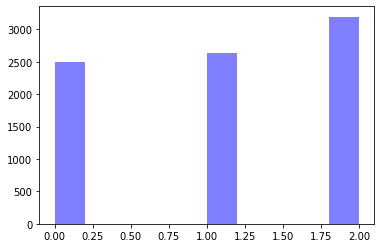

In [76]:
plt.hist(truths,color='b',range=(0.,2.),bins=10,alpha=0.5)
plt.show()

In [77]:
print(type(sys[0]))
print(len(sys[0]))

print(type(sys[0][0]))
print(len(sys[0][0]))

print(mult[0])
print(sys[0])
print(sys[0][0])

<class 'list'>
1
<class 'list'>
5
1.0
[[0.23562022140950334, 15.101940928295575, 5791.320213434841, 4.597703520878651, -0.39063293809485944]]
[0.23562022140950334, 15.101940928295575, 5791.320213434841, 4.597703520878651, -0.39063293809485944]


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  from ipykernel import kernelapp as app
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  app.launch_new_instance()


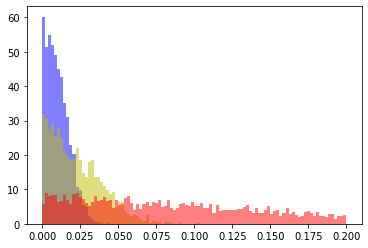

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


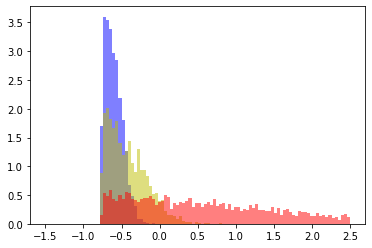

96.03785587376612
103.5638905906063


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:16: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


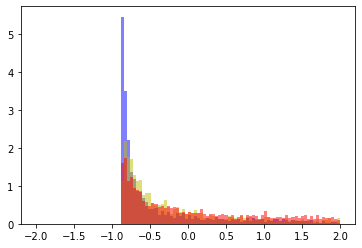

-0.8669068505538152
2.9315577910079575
8325
0


In [78]:
plt.hist(np.array(rad[truths==0]),normed=True,range=(0,0.2),bins=100,color='b',alpha=0.5)
plt.hist(np.array(rad[truths==1]),normed=True,range=(0,0.2),bins=100,color='y',alpha=0.5)
plt.hist(np.array(rad[truths==2]),normed=True,range=(0,0.2),bins=100,color='r',alpha=0.5)
plt.show()

scaledRad = (rad - np.mean(rad))/np.std(rad)
plt.hist(np.array(scaledRad[truths==0]),normed=True,range=(-1.5,2.5),bins=100,color='b',alpha=0.5)
plt.hist(np.array(scaledRad[truths==1]),normed=True,range=(-1.5,2.5),bins=100,color='y',alpha=0.5)
plt.hist(np.array(scaledRad[truths==2]),normed=True,range=(-1.5,2.5),bins=100,color='r',alpha=0.5)
plt.show()

scaledPer = (pers - np.mean(pers))/np.std(pers)
print(np.mean(pers))
print(np.std(pers))
plt.hist(np.array(scaledPer[truths==0]),normed=True,range=(-2.,2.),bins=100,color='b',alpha=0.5)
plt.hist(np.array(scaledPer[truths==1]),normed=True,range=(-2.,2.),bins=100,color='y',alpha=0.5)
plt.hist(np.array(scaledPer[truths==2]),normed=True,range=(-2.,2.),bins=100,color='r',alpha=0.5)
plt.show()

print(np.min(scaledPer))
print(np.max(scaledPer))
print(len(scaledPer))
print(len(scaledPer[np.isnan(scaledPer)]))

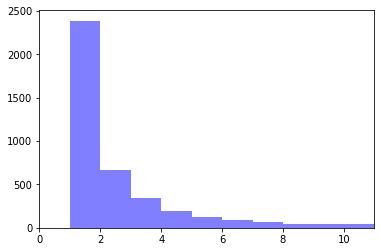

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [79]:
plt.hist(mult,color='b',range=(1,11),bins=10,alpha=0.5)
plt.xlim(0,11)
plt.show()
print(np.unique(mult))

In [80]:
M = len(truths)
q0 = len(truths[truths==0])/M
q1 = len(truths[truths==1])/M
q2 = len(truths[truths==2])/M

print(q0)
print(q1)
print(q2)
print(q0+q1+q2)

entropy = q0*np.log(q0) +  q1*np.log(q1) +  q2*np.log(q2)

print(entropy)

0.29945945945945945
0.31663663663663666
0.3839039039039039
1.0
-1.0927487595461756
